In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score, f1_score, roc_auc_score, precision_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from matplotlib import cm
import datetime
from random import randint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rashi/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# get some data
x_train = np.loadtxt('files/x_train.dat')
y_train = np.loadtxt('files/y_train.dat')
x_test = np.loadtxt('files/x_test.dat')
y_test = np.loadtxt('files/y_test.dat')

features = np.genfromtxt('files/features.dat', delimiter='\t', dtype='str')
print(features)
print(shape(features))

['Weight' 'Exercise Status' 'Before Exercise' 'After Exercise'
 'Sensor Mean' 'Manual Mean' 'Sensor Stdev' 'Manual Stdev' 'Median Sensor'
 'Median Manual' 'Calibrations' 'Discrepancy Mean' 'Discrepancy Stdev'
 'Peaks' 'Valleys' 'Drop from Exercise' 'BMI']
(17,)


### No need to train explicitly here, since validation is already storing a trained model

In [3]:
########################################### Testing ####################################################
def testing(x_test, model):
  y_pred = model.predict(x_test)
  prob = model.predict_proba(x_test) # To get confidence of the prediction
  return np.array(y_pred), np.array(prob)

model = joblib.load('test_models/model.pkl')
y_pred, prob = testing(x_test, model)

In [4]:
def plot_confusion_matrix(cm, ylabel, xlabel):
  plt.figure()
  cmap = plt.cm.Oranges
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title('Normalized Confusion Matrix', fontsize=16)
  plt.colorbar()
  for (i, j), z in np.ndenumerate(cm):
    if(z<0.5):
        color = 'k'
    else:
        color = 'w' # hard to read black on dark backgrounds
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', color=color, fontsize=16)
# write cm values on grid
  tick_labels = ['no episode', 'episode']
  tick_marks = np.arange(len(tick_labels))
  plt.xticks(tick_marks, tick_labels, fontsize=13, rotation=45)
  plt.yticks(tick_marks, tick_labels, fontsize=13, rotation=45)
  plt.tight_layout()
  plt.ylabel(ylabel, fontsize=16)
  plt.xlabel(xlabel, fontsize=16)

from matplotlib import cm

def plot_hist(prob_meta, prob_prec):
  fig = plt.figure()
  ax1 = fig.add_subplot(211)
  ax2 = fig.add_subplot(212)

  results, edges = np.histogram(prob_meta, bins=np.linspace(0,1,21,endpoint=True) , normed=True)
  binWidth = edges[1] - edges[0]
  ax1.bar(edges[:-1], results*binWidth, binWidth, facecolor='b', label='No Episode')  
  ax1.axvline(x=0.5, c='k', ls='--')

  results, edges = np.histogram(prob_prec, bins=np.linspace(0,1,21,endpoint=True), normed=True)

  binWidth = edges[1] - edges[0]
  ax2.bar(edges[:-1], results*binWidth, binWidth, facecolor='r', label='Episode')
  ax2.axvline(x=0.5, c='k', ls='--')

  ax1.set_xlim(0,1)
  ax2.set_xlim(0,1)
  ax1.set_ylim(0,0.5)
  ax2.set_ylim(0,0.5)

  plt.suptitle('Spread of Classification Probabilities', fontsize=15)
  ax1.set_ylabel('Probability', fontsize=15)
  ax2.set_ylabel('Probability', fontsize=15)
  ax2.set_xlabel('Episode Classification Probability', fontsize=15)
  ax1.legend(loc='best', fontsize=20)
  ax2.legend(loc='best', fontsize=20)
  #plt.tight_layout()

correct predictions (0 in 0 & 1 in 1): 80.65
mean probabilities = for 0: 0.55 & for 1: 0.45
Confusion Matrix true_pred:
 [[15  2]
 [ 4 10]]
recall_score 0.71
precision_score 0.83
f1_score 0.77
roc_auc_score 0.8


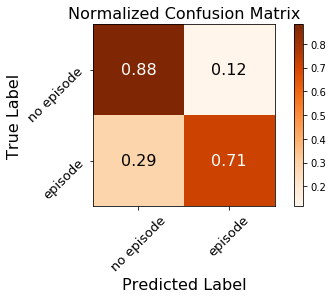

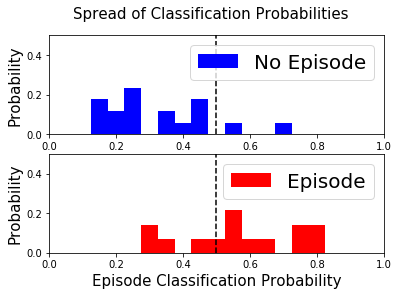

In [5]:
################################################# Prediction & Performance ################################################# 
def prediction(x_test, y_test, y_pred, prob, model):
  cm_true_pred = confusion_matrix(y_test, y_pred, labels = [0, 1])
  ncm_true_pred = cm_true_pred.astype('float') / cm_true_pred.sum(axis=1)[:, np.newaxis]
# Normalize the confusion matrix by row (i.e by the number of samples in each class)

  print("correct predictions (0 in 0 & 1 in 1):", np.round((cm_true_pred[0][0]+cm_true_pred[1][1])*100.0/np.sum(cm_true_pred), 2))
  print("mean probabilities = for 0:", np.round(np.mean(prob[:,0]), 2), '& for 1:', np.round(np.mean(prob[:,1]), 2))
  print("Confusion Matrix true_pred:\n", cm_true_pred)
  plot_confusion_matrix(ncm_true_pred, 'True Label', 'Predicted Label')

#  print("oob_score", np.round(model.oob_score_, 2))
# RandomizedSearchCV apparently doesn't have this attribute. Go figure

  print("recall_score", np.round(recall_score(y_test, y_pred, average='binary'), 2))
  print("precision_score", np.round(precision_score(y_test, y_pred, average='binary'), 2))
  print("f1_score", np.round(f1_score(y_test, y_pred, average='binary'), 2))
  print("roc_auc_score", np.round(roc_auc_score(y_test, y_pred), 2))
  
# plot 1D histogram of hypo '1' probabilities in '0' and '1' regions:
  prob_0 = prob[y_test == 0, 1]
  prob_1 = prob[y_test == 1, 1]
  plot_hist(prob_0, prob_1)

prediction(x_test, y_test, y_pred, prob, model)

Importances Sum: 1.0
Feature ranking:
1. feature 1 (0.001352)
2. feature 10 (0.008732)
3. feature 4 (0.032272)
4. feature 7 (0.032534)
5. feature 15 (0.037526)
6. feature 6 (0.038952)
7. feature 14 (0.042047)
8. feature 12 (0.046309)
9. feature 9 (0.048438)
10. feature 13 (0.057986)
11. feature 11 (0.063187)
12. feature 0 (0.067046)
13. feature 8 (0.068480)
14. feature 5 (0.071675)
15. feature 2 (0.087577)
16. feature 16 (0.112991)
17. feature 3 (0.182896)


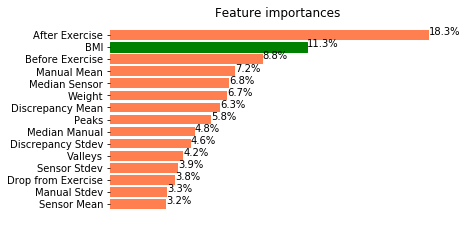

In [6]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)
print("Importances Sum:", np.sum(importances))

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

n = 2
# getting rid of n least important features:    
x_feat = range(n, x_train.shape[1]); y_feat = importances[indices[n:]]
labels = features[indices[n:]] 

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
barlist = plt.barh(x_feat, y_feat, color="coral", align="center")
# annotating bars with values:
for a,b in zip(y_feat, x_feat):
    value = np.round((a*100),1)
    plt.text(a, b, str(value)+'%')
    
barlist[-2].set_color('g')
# Importance of BMI!

ax = plt.gca()
# removing frame around plot:
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# removing xlabels:
ax.get_xaxis().set_ticks([])

# renaming ylabels with feature names:
plt.yticks(x_feat, labels)
plt.ylim([-1, x_train.shape[1]])
plt.show()